<a href="https://colab.research.google.com/github/Alexandre-Rafael/trabalho_visao/blob/main/Classificando_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANDO AS BIBLIOTECAS

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt


import torch
import time
import os



from torch.nn import functional as F
from torch.utils.data import Dataset

from torchvision import transforms

IMPORTANDO O DATA SET





In [ ]:
from google.colab import files
import zipfile

uploaded = files.upload()

for filename in uploaded.keys():
    zip_path = os.path.join("/content", filename)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/dataset")

print("Dataset extraído para /content/dataset/mpeg7_mod")
DS_PATH = '/content/dataset/mpeg7_mod'

IMAGE_PATH = DS_PATH


print(f"Caminho base do dataset: {DS_PATH}")
print(f"Caminho para as imagens: {IMAGE_PATH}")




Saving mpeg7_mod.zip to mpeg7_mod.zip
Dataset extraído para /content/dataset/mpeg7_mod
Caminho base do dataset: /content/dataset/mpeg7_mod
Caminho para as imagens: /content/dataset/mpeg7_mod


CONFIGURAÇÕES PRO MODELO

In [ ]:
NUM_EPOCHS = 40
BATCH_SIZE = 64
NUM_CHANNELS = 1
NUM_CLASSES = 6
INPUT_WIDTH = 256
INPUT_HEIGHT = 256

TRANSFORMANDO IMAGENS EM 128 x 128

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


EXTRAINDO CARACTERÍSTICAS MORFOLÓGICAS

In [ ]:
import cv2
import pandas as pd
from glob import glob

DS_PATH = '/content/dataset/mpeg7_mod'
print(f"Caminho base do dataset: {DS_PATH}")

def extract_morphological_features(IMAGE_PATH):
    image = cv2.imread(IMAGE_PATH, 0)

    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(largest_contour)

    perimeter = cv2.arcLength(largest_contour, True)

    if perimeter != 0:
        circularity = (4 * np.pi * area) / (perimeter ** 2)
    else:
        circularity = 0

    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h

    moments = cv2.moments(largest_contour)
    if moments["mu20"] + moments["mu02"] != 0:
        eccentricity = (moments["mu20"] - moments["mu02"]) ** 2 / (moments["mu20"] + moments["mu02"])
    else:
        eccentricity = 0

    return {
        "Area": area,
        "Perimeter": perimeter,
        "Circularity": circularity,
        "Aspect Ratio": aspect_ratio,
        "Eccentricity": eccentricity,
    }

class_names = os.listdir(DS_PATH)
features = []

for class_name in class_names:
    class_folder = os.path.join(DS_PATH, class_name)
    if os.path.isdir(class_folder):
        images = glob(os.path.join(class_folder, "*.png"))
        for IMAGE_PATH in images:
            feature = extract_morphological_features(IMAGE_PATH)
            feature["Class"] = class_name
            features.append(feature)

features_df = pd.DataFrame(features)

print(features_df.head())

features_df.to_csv("morphological_features.csv", index=False)
print("Características salvas em 'morphological_features.csv'")


Caminho base do dataset: /content/dataset/mpeg7_mod
      Area   Perimeter  Circularity  Aspect Ratio  Eccentricity Class
0  25442.0  757.470124     0.557224      1.281768  6.581058e+05  bell
1   2499.0  240.308655     0.543798      1.088235  3.400034e+02  bell
2   5266.0  311.137083     0.683577      1.320000  4.873841e+05  bell
3  25082.5  837.913775     0.448934      0.377581  1.265963e+08  bell
4  25070.5  802.707711     0.488943      0.529412  5.510372e+07  bell
Características salvas em 'morphological_features.csv'


In [ ]:
from sklearn.model_selection import train_test_split

X = features_df.drop(columns=["Class"])
y = features_df["Class"]


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")


Tamanho do conjunto de treino: 420
Tamanho do conjunto de validação: 90
Tamanho do conjunto de teste: 90


In [ ]:

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42
)


NORMALIZANDO OS DADOS


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Dados normalizados (treino):")
print(X_train_scaled[:5])


Dados normalizados (treino):
[[2.01509519e-01 1.66034520e-01 4.92592754e-01 8.61685291e-02
  9.41023541e-03]
 [2.54055187e-01 1.53513401e-01 7.14940544e-01 5.97857754e-02
  2.34864228e-07]
 [2.21141056e-01 2.77528116e-01 1.98466365e-01 4.98221040e-02
  6.84486921e-02]
 [2.70465963e-01 2.36739121e-01 3.46560729e-01 1.00462711e-01
  3.33148633e-02]
 [9.13502346e-01 5.66050021e-01 2.18874338e-01 2.98870386e-02
  5.70902912e-01]]


MODELO KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

k_values = [3, 5, 7]
train_accuracies = []
val_accuracies = []

X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

print("Treinando o modelo k-NN...\n")
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Época {epoch}/{NUM_EPOCHS}:")

    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)

        knn_model.fit(X_train_temp, y_train_temp)

        train_acc = knn_model.score(X_train_temp, y_train_temp)
        train_accuracies.append(train_acc)

        val_acc = knn_model.score(X_val, y_val)
        val_accuracies.append(val_acc)

        print(f"  k = {k}: Acurácia no treino: {train_acc:.4f}, Acurácia na validação: {val_acc:.4f}")

    print("-" * 40)

best_k = k_values[val_accuracies.index(max(val_accuracies)) % len(k_values)]
print(f"\nMelhor valor de k baseado na validação: {best_k}\n")

final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(X_train_scaled, y_train)

y_pred_knn = final_knn_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred_knn)

print("Avaliação Final no Conjunto de Teste:")
print(f"Acurácia no teste: {test_acc:.4f}")
print("\nRelatório de Classificação no Teste:")
print(classification_report(y_test, y_pred_knn))


Treinando o modelo k-NN...

Época 1/40:
  k = 3: Acurácia no treino: 0.9388, Acurácia na validação: 0.8651
  k = 5: Acurácia no treino: 0.9184, Acurácia na validação: 0.8492
  k = 7: Acurácia no treino: 0.8776, Acurácia na validação: 0.8175
----------------------------------------
Época 2/40:
  k = 3: Acurácia no treino: 0.9388, Acurácia na validação: 0.8651
  k = 5: Acurácia no treino: 0.9184, Acurácia na validação: 0.8492
  k = 7: Acurácia no treino: 0.8776, Acurácia na validação: 0.8175
----------------------------------------
Época 3/40:
  k = 3: Acurácia no treino: 0.9388, Acurácia na validação: 0.8651
  k = 5: Acurácia no treino: 0.9184, Acurácia na validação: 0.8492
  k = 7: Acurácia no treino: 0.8776, Acurácia na validação: 0.8175
----------------------------------------
Época 4/40:
  k = 3: Acurácia no treino: 0.9388, Acurácia na validação: 0.8651
  k = 5: Acurácia no treino: 0.9184, Acurácia na validação: 0.8492
  k = 7: Acurácia no treino: 0.8776, Acurácia na validação: 0.81

MODELO RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

NUM_EPOCHS = 40
n_estimators_values = [50, 100, 150]
max_depth_values = [None, 10, 20]

train_accuracies = []
val_accuracies = []

X_train_temp, X_val, y_train_temp, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=42)

print("Treinando o modelo Random Forest...\n")
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Época {epoch}/{NUM_EPOCHS}:")

    for n_estimators in n_estimators_values:
        for max_depth in max_depth_values:
            rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

            rf_model.fit(X_train_temp, y_train_temp)

            train_acc = rf_model.score(X_train_temp, y_train_temp)
            train_accuracies.append(train_acc)

            val_acc = rf_model.score(X_val, y_val)
            val_accuracies.append(val_acc)

            print(f"  n_estimators = {n_estimators}, max_depth = {max_depth}: "
                  f"Acurácia no treino: {train_acc:.4f}, Acurácia na validação: {val_acc:.4f}")

    print("-" * 40)

best_index = val_accuracies.index(max(val_accuracies))
best_n_estimators = n_estimators_values[best_index // len(max_depth_values)]
best_max_depth = max_depth_values[best_index % len(max_depth_values)]

print(f"\nMelhores Hiperparâmetros baseados na validação:")
print(f"n_estimators = {best_n_estimators}, max_depth = {best_max_depth}\n")

final_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
final_rf_model.fit(X_train_scaled, y_train)

y_pred_rf = final_rf_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred_rf)

print("Avaliação Final no Conjunto de Teste:")
print(f"Acurácia no teste: {test_acc:.4f}")
print("\nRelatório de Classificação no Teste:")
print(classification_report(y_test, y_pred_rf))


Treinando o modelo Random Forest...

Época 1/40:
  n_estimators = 50, max_depth = None: Acurácia no treino: 1.0000, Acurácia na validação: 0.9286
  n_estimators = 50, max_depth = 10: Acurácia no treino: 1.0000, Acurácia na validação: 0.9286
  n_estimators = 50, max_depth = 20: Acurácia no treino: 1.0000, Acurácia na validação: 0.9286
  n_estimators = 100, max_depth = None: Acurácia no treino: 1.0000, Acurácia na validação: 0.9365
  n_estimators = 100, max_depth = 10: Acurácia no treino: 1.0000, Acurácia na validação: 0.9286
  n_estimators = 100, max_depth = 20: Acurácia no treino: 1.0000, Acurácia na validação: 0.9365
  n_estimators = 150, max_depth = None: Acurácia no treino: 1.0000, Acurácia na validação: 0.9365
  n_estimators = 150, max_depth = 10: Acurácia no treino: 1.0000, Acurácia na validação: 0.9365
  n_estimators = 150, max_depth = 20: Acurácia no treino: 1.0000, Acurácia na validação: 0.9365
----------------------------------------
Época 2/40:
  n_estimators = 50, max_depth 

GERANDO MATRIZ DE CONFUSÃO

Matriz de Confusão - k-NN


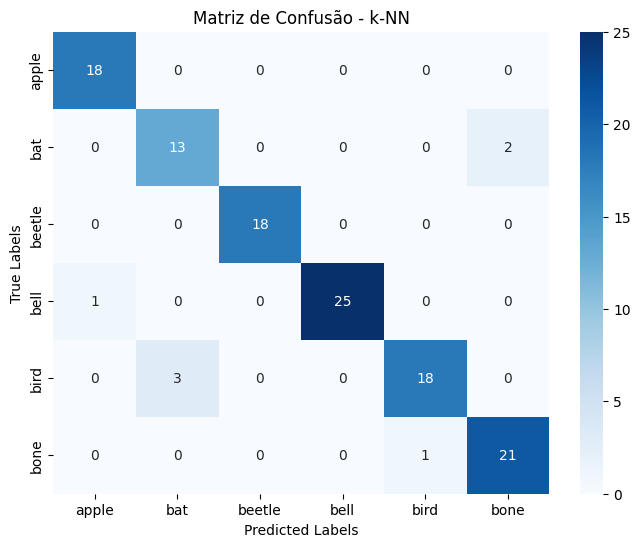

Matriz de Confusão - Random Forest


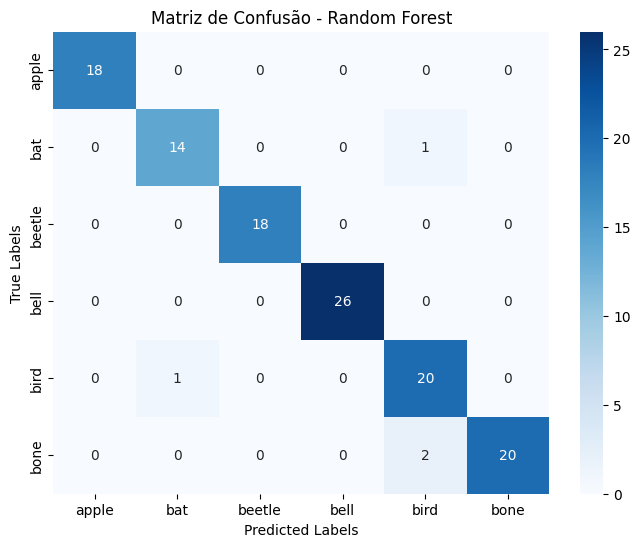

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Função para plotar e salvar a matriz de confusão
def plot_and_save_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.savefig(filename, dpi=300)  # Salva a figura no arquivo com alta resolução
    plt.show()

# Avaliação do k-NN
print("Matriz de Confusão - k-NN")
y_pred_knn = final_knn_model.predict(X_test_scaled)
plot_and_save_confusion_matrix(y_test, y_pred_knn, "Matriz de Confusão - k-NN", "confusion_matrix_knn.png")

# Avaliação do Random Forest
print("Matriz de Confusão - Random Forest")
y_pred_rf = final_rf_model.predict(X_test_scaled)
plot_and_save_confusion_matrix(y_test, y_pred_rf, "Matriz de Confusão - Random Forest", "confusion_matrix_rf.png")

